## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from scripts_step_lr_schedulers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
# Unzip files
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-96-complete-trans-pt/fold_1.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-96-complete-trans-pt/fold_2.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-96-complete-trans-pt/fold_3.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-96-complete-trans-pt/fold_4.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-96-complete-trans-pt/fold_5.tar.gz

In [3]:
database_base_path = '/kaggle/input/tweet-dataset-5fold-roberta-96-complete-trans-pt/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
print(f'Training set samples: {len(k_fold)}')
display(k_fold.head())

Training set samples: 29592


,textID,text,selected_text,sentiment,fold_1,fold_2,fold_3,fold_4,fold_5,imputed,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,train,train,train,validation,train,False,1.000000,35,7,10,35,7,10
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,validation,train,train,train,train,False,0.200000,45,10,13,8,2,3
2,088c60f138,my boss is bullying me...,bullying me,negative,train,validation,train,train,train,False,0.166667,25,5,6,11,2,2
3,9642c003ef,what interview! leave me alone,leave me alone,negative,train,validation,train,train,train,False,0.600000,30,5,6,14,3,3
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,train,train,validation,train,train,False,0.214286,74,14,17,13,3,4


# Model parameters

In [4]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  'MAX_LEN': 96,
  'BATCH_SIZE': 32,
  'EPOCHS': 7,
  'LEARNING_RATE': 3e-5,
  'ES_PATIENCE': 2,
  'N_FOLDS': 5,
  'question_size': 4,
  'base_model_path': base_path + 'roberta-base-tf_model.h5',
  'config_path': base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [5]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

Learning rate schedule: 1e-07 to 2.97e-05 to 1e-06


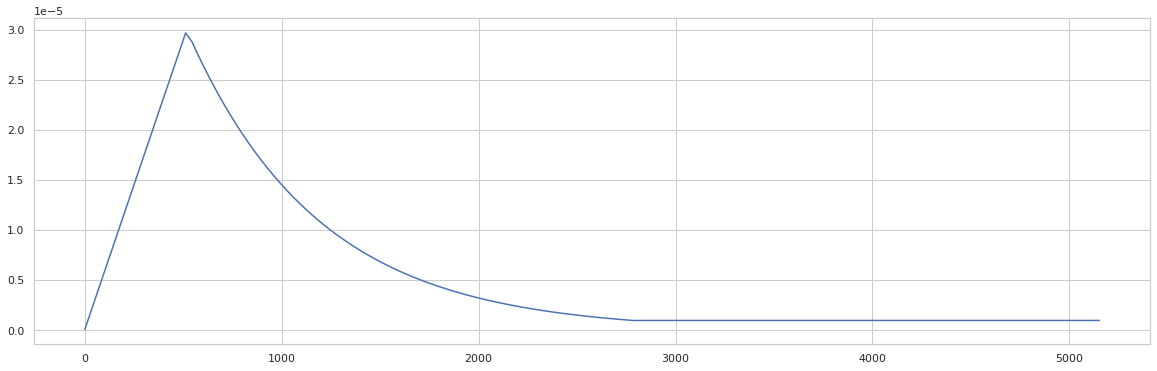

In [6]:
lr_min = 1e-6
lr_start = 1e-7
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train'])
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
warmup_steps = total_steps * 0.1
decay = .9985

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=warmup_steps, lr_start=lr_start, 
                                      lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [7]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _  = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    logits = layers.Dense(2, name="qa_outputs")(last_hidden_state)
    
    start_logits, end_logits = tf.split(logits, 2, axis=-1)
    start_logits = tf.squeeze(start_logits, axis=-1)
    end_logits = tf.squeeze(end_logits, axis=-1)

    model = Model(inputs=[input_ids, attention_mask], outputs=[start_logits, end_logits])
    
    return model

# Train

In [8]:
# Datasets
def get_training_dataset(x_train, y_train, batch_size, buffer_size, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 'attention_mask': x_train[1]}, 
                                                  (y_train[0], y_train[1])))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size, repeated=False, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 'attention_mask': x_valid[1]}, 
                                                  (y_valid[0], y_valid[1])))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=warmup_steps, lr_start=lr_start, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))
    
    model.compile(optimizer, loss=[losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True),
                                   losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)])
    
    history = model.fit(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO, seed=SEED),
                        validation_data=(get_validation_dataset(x_valid, y_valid, config['BATCH_SIZE'], AUTO, repeated=False, seed=SEED)),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es],
                        verbose=2).history
    
    history_list.append(history)

    # Make predictions
#     predict_eval_df(k_fold, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])
    
    ### Delete data dir
    shutil.rmtree(base_data_path)


FOLD: 1
Train for 739 steps, validate for 171 steps
Epoch 1/7
739/739 - 298s - loss: 4.8633 - tf_op_layer_Squeeze_loss: 2.4057 - tf_op_layer_Squeeze_1_loss: 2.4576 - val_loss: 4.0427 - val_tf_op_layer_Squeeze_loss: 2.0329 - val_tf_op_layer_Squeeze_1_loss: 2.0099
Epoch 2/7
739/739 - 286s - loss: 3.9921 - tf_op_layer_Squeeze_loss: 2.0135 - tf_op_layer_Squeeze_1_loss: 1.9786 - val_loss: 3.9660 - val_tf_op_layer_Squeeze_loss: 2.0052 - val_tf_op_layer_Squeeze_1_loss: 1.9608
Epoch 3/7
739/739 - 286s - loss: 3.8898 - tf_op_layer_Squeeze_loss: 1.9659 - tf_op_layer_Squeeze_1_loss: 1.9239 - val_loss: 3.9657 - val_tf_op_layer_Squeeze_loss: 2.0081 - val_tf_op_layer_Squeeze_1_loss: 1.9576
Epoch 4/7
739/739 - 286s - loss: 3.8449 - tf_op_layer_Squeeze_loss: 1.9431 - tf_op_layer_Squeeze_1_loss: 1.9018 - val_loss: 3.9619 - val_tf_op_layer_Squeeze_loss: 2.0045 - val_tf_op_layer_Squeeze_1_loss: 1.9574
Epoch 5/7
739/739 - 285s - loss: 3.8325 - tf_op_layer_Squeeze_loss: 1.9357 - tf_op_layer_Squeeze_1_loss

# Model loss graph

Fold: 1


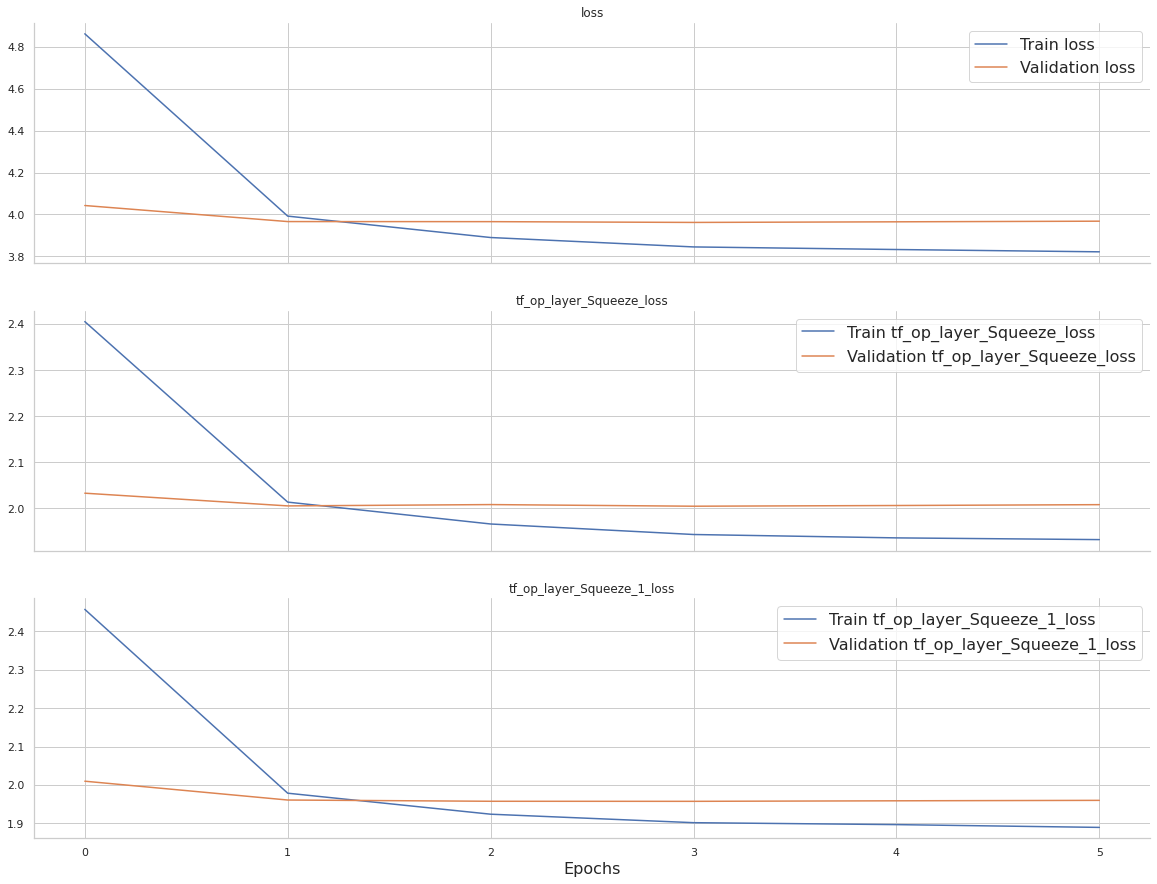

Fold: 2


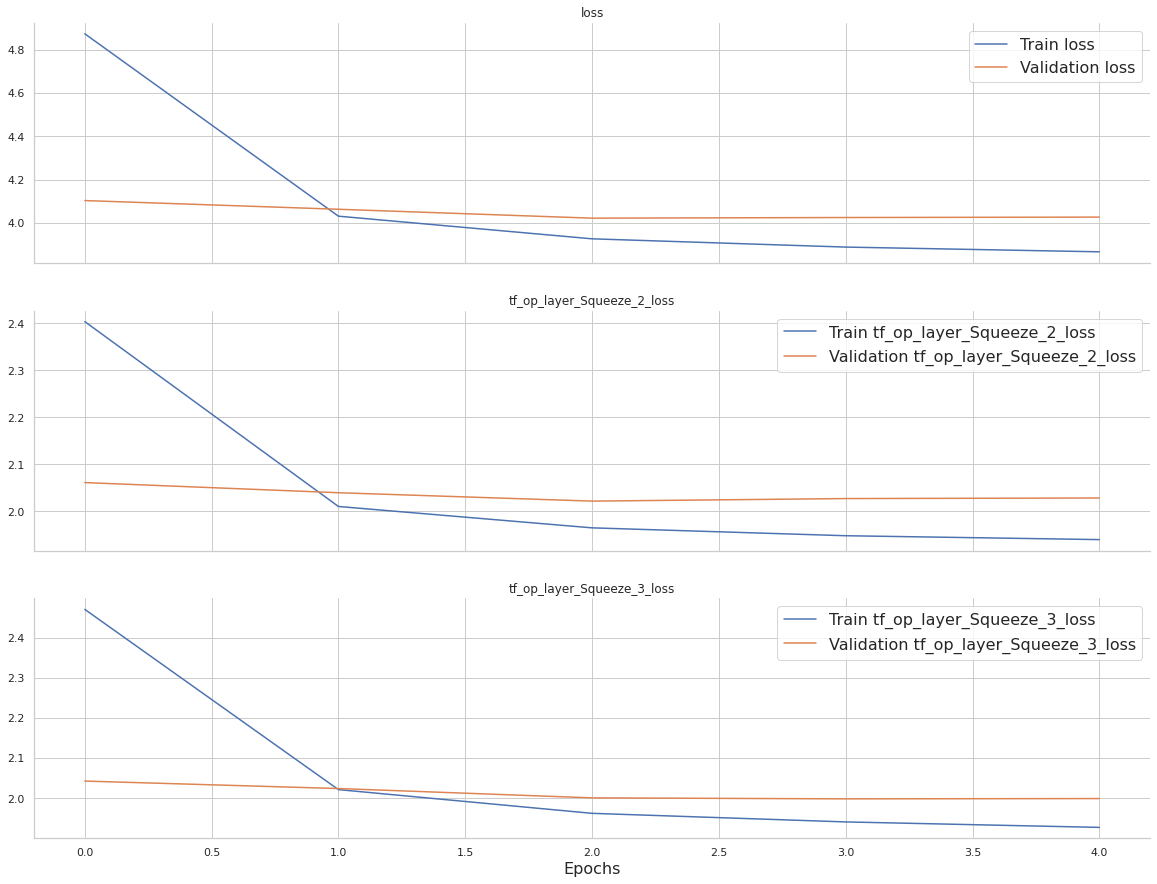

Fold: 3


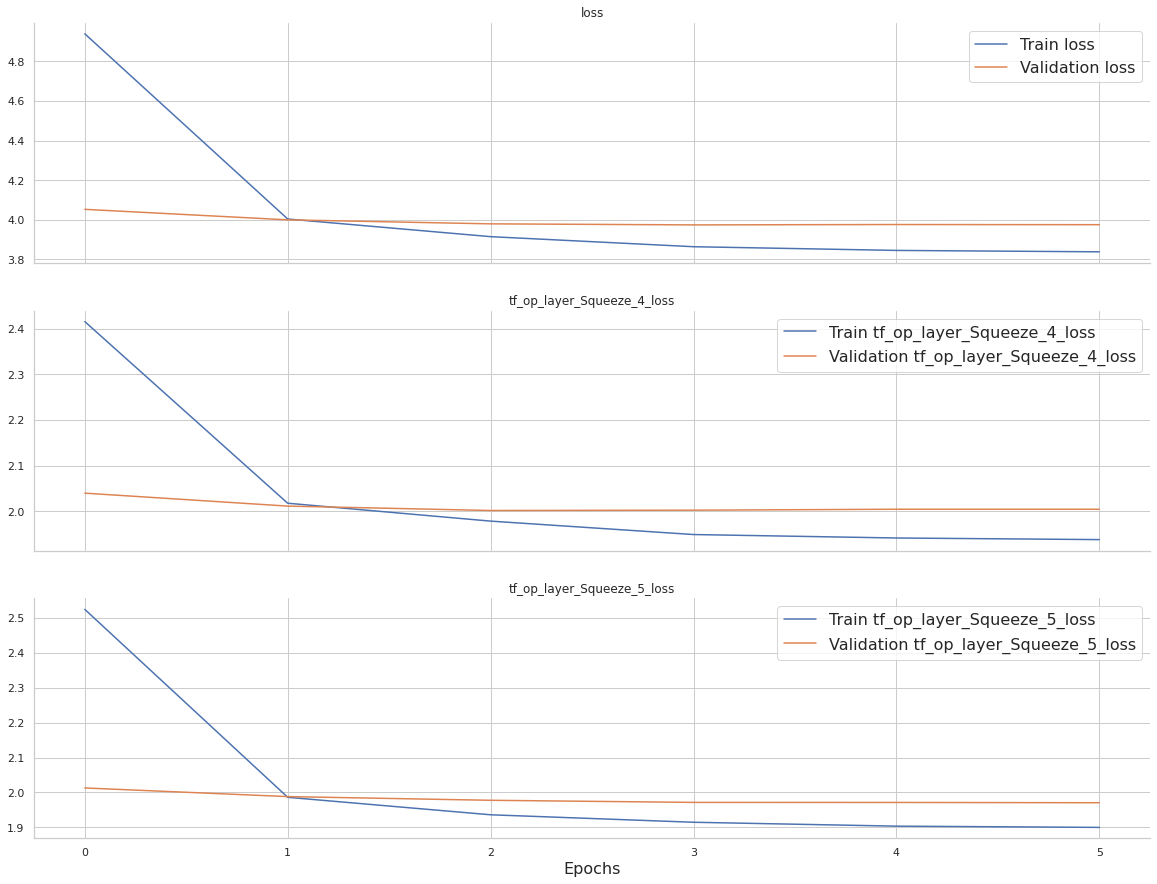

Fold: 4


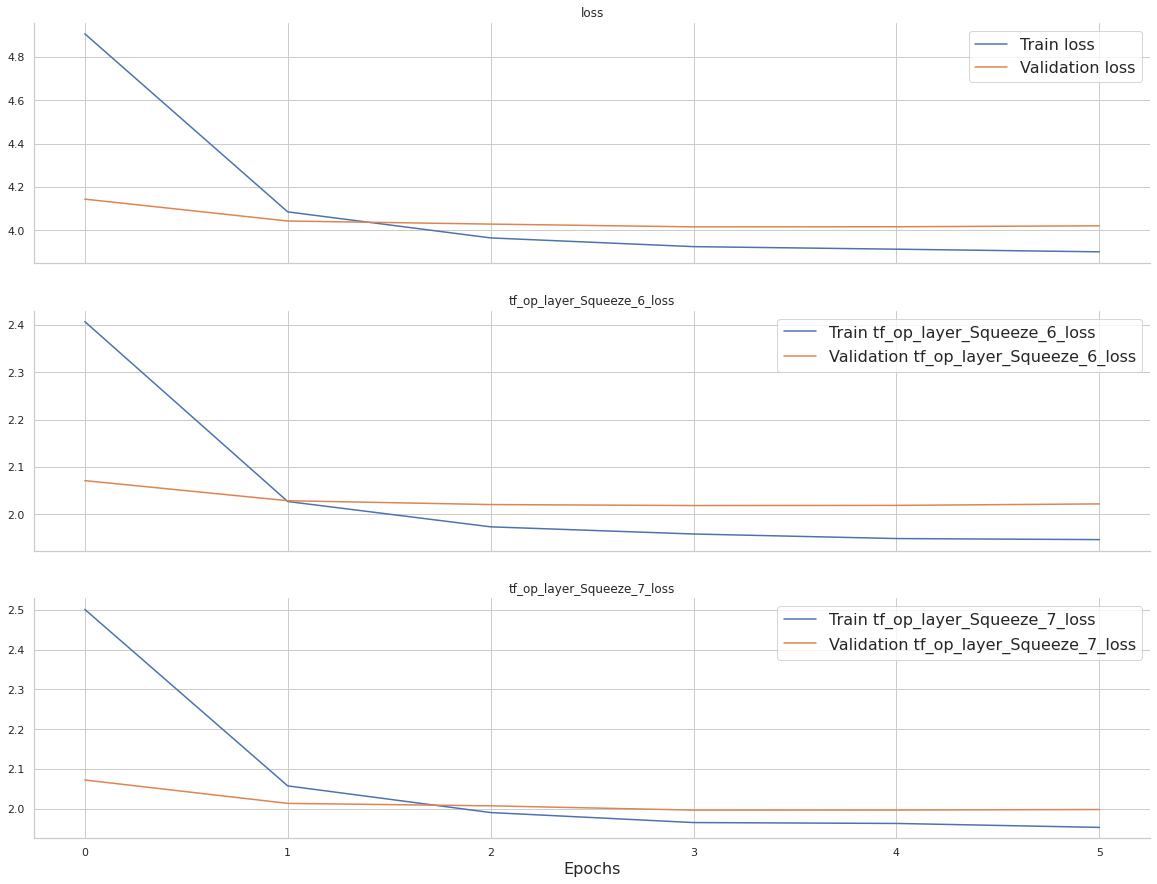

Fold: 5


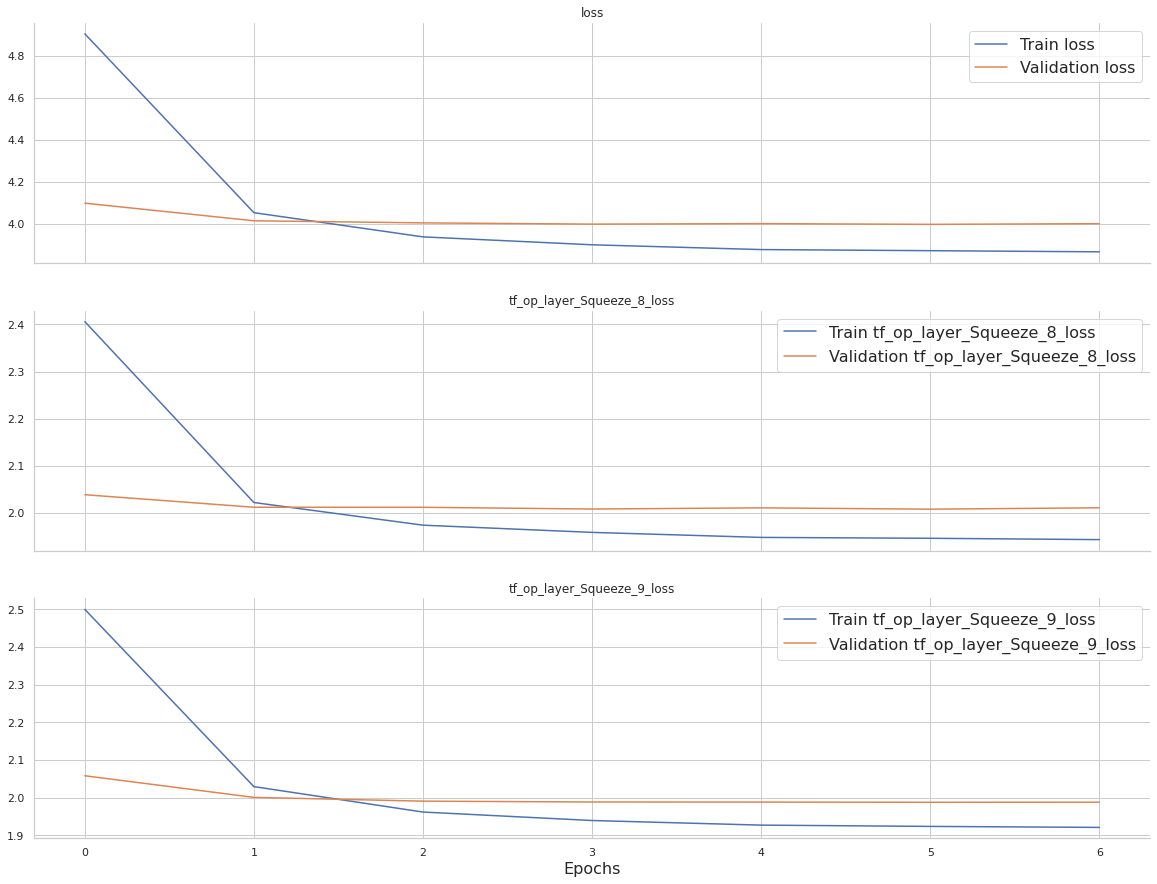

In [10]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [11]:
# display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

# Visualize predictions

In [12]:
# k_fold['jaccard_mean'] = 0

# for n in range(config['N_FOLDS']):
#     k_fold['jaccard_mean'] += k_fold[f'jaccard_fold_{n+1}'] / config['N_FOLDS']

# display(k_fold[['text', 'selected_text', 'sentiment', 'text_tokenCnt', 
#                 'selected_text_tokenCnt', 'jaccard', 'jaccard_mean'] + [c for c in k_fold.columns if (c.startswith('prediction_fold'))]].head(15))